# Intro Task, Object Localization 

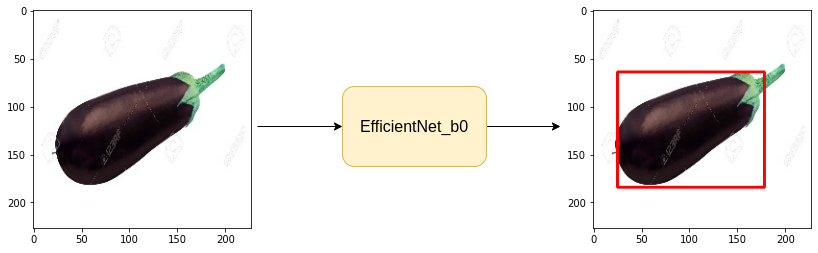

In [1]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-nt566sci
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-nt566sci
     |████████████████████████████████| 47.7 MB 1.4 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112536 sha256=c8187943b027d9b91d310b21767fd7b9f27f7121522c4f49259d85fe98069607
  Stored in directory: /tmp/pip-ephem-wheel-cache-sp0cb40l/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 431 kB 5.3 MB/s 
     |████████████████████████████████| 66.6 MB 127 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.

In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 15.39 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [8]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [9]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [18]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'
DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140
LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUR_COR = 4

In [19]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

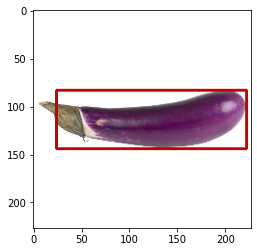

In [32]:
row = df.iloc[6]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (200,0,0),2)
plt.imshow(bnd_box_img)

In [33]:
train_df, valid_df = train_test_split(df, test_size= 0.20, random_state=42)

# Augmentations

In [34]:
import albumentations as A

In [35]:
train_augs = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate()
],bbox_params=A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
],bbox_params=A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

# Create Custom Dataset

In [36]:
from albumentations import augmentations
class ObjLocDataset(torch.utils.data.Dataset):

  def __init__(self, df, augmentations = None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    xmin = row.xmin
    xmax = row.xmax
    ymin = row.ymin
    ymax = row.ymax
    bbox = [[xmin,ymin,xmax,ymax]]

    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
      img = data['image']
      bbox = data['bboxes'][0]  # bbox = [[xmin,ymin,xmax,ymax]]

    img = torch.from_numpy(img).permute(2,0,1)/255.0  # (h,w,c) -> (c,h,w)
    bbox = torch.Tensor(bbox)

    return img, bbox
    


In [37]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [38]:
print(f'Total examples in the trainset: {len(trainset)}')
print(f'Total examples in the trainset: {len(validset)}')

Total examples in the trainset: 148
Total examples in the trainset: 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


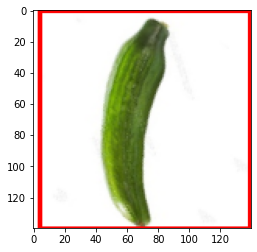

In [42]:
img, bbox = trainset[6]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [47]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

In [48]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [49]:
for images, bboxes in trainloader:
  break


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [50]:
from torch import nn 
import timm

In [51]:
class ObjLocModel(nn.Module):

  def __init__(self):
    super(ObjLocModel, self).__init__()

    self.backbone = timm.create_model(MODEL_NAME, pretrained = True, num_classes = 4)

  def forward(self, images, gt_bboxes = None):

    bboxes = self.backbone(images)

    if gt_bboxes != None:

      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss
    
    return bboxes

In [54]:
model = ObjLocModel()
model.to(DEVICE);

In [57]:
random_img = torch.rand(1,3,140,140).to(DEVICE)
model(random_img)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [66]:
def train_function(model, dataloader, optimizer):

  total_loss = 0.0
  model.train() # Dropout ON

  for data in tqdm(dataloader):

    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

    bboxes, loss = model(images, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)

  return avg_loss

In [67]:
def eval_function(model, dataloader):

  total_loss = 0.0
  model.eval() # Dropout OFF

  with torch.no_grad():
    for data in tqdm(dataloader):

      images, gt_bboxes = data
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

      bboxes, loss = model(images, gt_bboxes)

      total_loss += loss.item()
      avg_loss = total_loss / len(dataloader)

    return avg_loss

#Training Loop

In [68]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [71]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_function(model, trainloader, optimizer)
  valid_loss = eval_function(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('Weights are saved!')
    best_valid_loss = valid_loss
  
  print(f'Epoch : {i + 1} trian loss : {train_loss} valid loss : {valid_loss}')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!
Epoch : 1 trian loss : 679.8922973632813 valid loss : 251.59270222981772


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!
Epoch : 2 trian loss : 540.494839477539 valid loss : 228.44261169433594


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!
Epoch : 3 trian loss : 386.57593841552733 valid loss : 188.0753377278646


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 4 trian loss : 299.979736328125 valid loss : 252.71331278483072


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!
Epoch : 5 trian loss : 254.69365997314452 valid loss : 183.07186381022134


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!
Epoch : 6 trian loss : 180.29961700439452 valid loss : 174.13219706217447


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 trian loss : 149.22444763183594 valid loss : 198.56518046061197


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!
Epoch : 8 trian loss : 123.98385848999024 valid loss : 148.44769795735678


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!
Epoch : 9 trian loss : 98.2431427001953 valid loss : 133.1374053955078


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!
Epoch : 10 trian loss : 106.93488845825195 valid loss : 110.59825388590495


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 11 trian loss : 101.62144012451172 valid loss : 163.7254435221354


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!
Epoch : 12 trian loss : 91.34770126342774 valid loss : 96.23257191975911


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 13 trian loss : 81.95132293701172 valid loss : 97.1421890258789


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 14 trian loss : 73.31247138977051 valid loss : 119.68789927164714


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!
Epoch : 15 trian loss : 67.32769432067872 valid loss : 78.8268191019694


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!
Epoch : 16 trian loss : 68.47259368896485 valid loss : 71.52141443888347


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 17 trian loss : 65.64764175415038 valid loss : 85.7145512898763


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 18 trian loss : 48.536126899719235 valid loss : 81.67280451456706


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!
Epoch : 19 trian loss : 55.53589572906494 valid loss : 68.8632329305013


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 20 trian loss : 39.63692226409912 valid loss : 81.62425740559895


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 21 trian loss : 76.551220703125 valid loss : 69.49756113688152


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 22 trian loss : 51.082993507385254 valid loss : 73.21476745605469


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 23 trian loss : 47.758463287353514 valid loss : 75.40094248453777


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 24 trian loss : 57.385705184936526 valid loss : 69.28891118367513


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!
Epoch : 25 trian loss : 41.721319389343265 valid loss : 55.159077962239586


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 26 trian loss : 50.65944957733154 valid loss : 64.43324788411458


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 27 trian loss : 41.39492645263672 valid loss : 79.90237681070964


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 28 trian loss : 40.47517776489258 valid loss : 71.24825032552083


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 29 trian loss : 40.32735385894775 valid loss : 71.26815287272136


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 30 trian loss : 56.64746246337891 valid loss : 127.15813446044922


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 31 trian loss : 51.751143836975096 valid loss : 68.85693359375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 32 trian loss : 35.10219497680664 valid loss : 85.7741305033366


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 33 trian loss : 39.67136573791504 valid loss : 63.44529342651367


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 34 trian loss : 39.24877395629883 valid loss : 83.04599380493164


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 35 trian loss : 54.99169521331787 valid loss : 71.0581563313802


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 36 trian loss : 39.18582286834717 valid loss : 109.55044301350911


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 37 trian loss : 37.994009017944336 valid loss : 61.480977376302086


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 38 trian loss : 42.71481189727783 valid loss : 56.30632527669271


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 39 trian loss : 47.21734046936035 valid loss : 56.50844065348307


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 40 trian loss : 41.466390228271486 valid loss : 57.7373898824056


#Inference

In [73]:
import utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


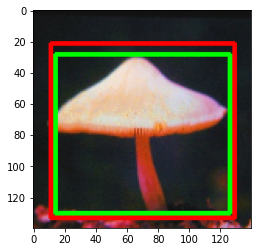

In [78]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():

  image, gt_bbox = validset[5] #(c,h,w)
  image = image.unsqueeze(0).to(DEVICE) # (batch size, c, h, w)

  out_bbox = model(image)

  utils.compare_plots(image, gt_bbox, out_bbox)